In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from bart_survival import surv_bart as sb

### Generate Synthetic Healthcare Data

In [2]:
np.random.seed(42)
n = 500

# Covariates
age = np.random.normal(65, 10, n).clip(18, 100).astype(int)
gender = np.random.binomial(1, 0.5, n)
treatment = np.random.binomial(1, 0.4, n)
comorbidity = np.random.poisson(2, n).clip(0, 10)

# Generate survival times (exponential hazard with covariates)
base_hazard = 0.01  # daily hazard
log_hazard = (age - 65) * 0.02 + gender * 0.1 + (1 - treatment) * 0.3 + comorbidity * 0.05
daily_hazards = base_hazard * np.exp(log_hazard)
times = np.random.exponential(1 / daily_hazards)

# Censoring: 30% censored
censor_prob = 0.3
status = np.random.binomial(1, 1 - censor_prob, n)

# Round times to integers
times = np.round(times).astype(int)

# Create DataFrame
data = pd.DataFrame({
    'time': times,
    'status': status,
    'age': age,
    'gender': gender,
    'treatment': treatment,
    'comorbidity': comorbidity
})

print(data.head())
print(f"Dataset shape: {data.shape}")

   time  status  age  gender  treatment  comorbidity
0    22       1   69       1          1            2
1    39       1   63       1          0            5
2    65       1   71       0          1            1
3    16       0   80       1          0            6
4    31       1   62       1          0            0
Dataset shape: (500, 6)


### Data Preparation
Transform the data into the 'augmented' format required by BART-Survival. We use a time scale of 30 days (monthly discretization) for discrete-time analysis.

In [3]:
# Prepare training data
trn = sb.get_surv_pre_train(
    y_time=data['time'].values,
    y_status=data['status'].values,
    x=data[['age', 'gender', 'treatment', 'comorbidity']].values,
    time_scale=30
)

# Prepare test data (using the same data for demonstration; in practice, use hold-out)
post_test = sb.get_posterior_test(
    y_time=data['time'].values,
    y_status=data['status'].values,
    x=data[['age', 'gender', 'treatment', 'comorbidity']].values,
    time_scale=30
)

print(f"Training data shape: X={trn['x'].shape}, y={trn['y'].shape}")

Training data shape: X=(1962, 5), y=(1962, 1)


### Model Configuration
Define the BART model with appropriate split rules for continuous and categorical variables.

In [4]:
model_dict = {
    "trees": 50,
    "split_rules": [
        "pmb.ContinuousSplitRule()",  # time (implicit)
        "pmb.ContinuousSplitRule()",  # age
        "pmb.OneHotSplitRule()",      # gender
        "pmb.OneHotSplitRule()",      # treatment
        "pmb.ContinuousSplitRule()",  # comorbidity
    ]
}

### Sampler Configuration
Set MCMC sampling parameters.

In [5]:
sampler_dict = {
    "draws": 200,
    "tune": 200,
    "cores": 4,  # Adjust based on your machine
    "chains": 4,
    "compute_convergence_checks": False
}

### Instantiate and Fit the Model

In [6]:
# Instantiate the BART Survival Model
BSM = sb.BartSurvModel(model_config=model_dict, sampler_config=sampler_dict)

# Fit the model
BSM.fit(
    y=trn["y"],
    X=trn["x"],
    weights=trn["w"],
    coords=trn["coord"],
    random_seed=42
)

print("Model fitted successfully!")

Multiprocess sampling (4 chains in 4 jobs)
PGBART: [f]


Sampling 4 chains for 200 tune and 200 draw iterations (800 + 800 draws total) took 7 seconds.


Model fitted successfully!


### Posterior Predictive Sampling
Generate posterior predictive samples for evaluation.

In [15]:
# Sample posterior predictive
post1 = BSM.sample_posterior_predictive(X_pred=post_test["post_x"], coords=post_test["coords"])

# Convert to survival probabilities
sv_prob_dict = sb.get_sv_prob(post1)
sv_prob = sv_prob_dict['prob']

print(f"Survival probabilities shape: {sv_prob.shape}")

Sampling: [f]


Survival probabilities shape: (800, 500, 18)


In [16]:
sv_prob

array([[[0.00513324, 0.20687895, 0.20722821, ..., 0.15195363,
         0.15195363, 0.15195363],
        [0.01140253, 0.29572022, 0.28864166, ..., 0.17263962,
         0.17263962, 0.17263962],
        [0.00209944, 0.17846559, 0.20790345, ..., 0.16852685,
         0.16852685, 0.16852685],
        ...,
        [0.00373991, 0.17065463, 0.18129029, ..., 0.13083071,
         0.13083071, 0.13083071],
        [0.00783329, 0.28512304, 0.3777547 , ..., 0.23231145,
         0.23231145, 0.23231145],
        [0.01559275, 0.30925499, 0.39926355, ..., 0.21950226,
         0.21950226, 0.21950226]],

       [[0.00624557, 0.26447753, 0.24932321, ..., 0.24715621,
         0.24715621, 0.24715621],
        [0.00734746, 0.19125229, 0.27005081, ..., 0.31234703,
         0.31234703, 0.31234703],
        [0.00446586, 0.23843906, 0.16948785, ..., 0.10658675,
         0.10658675, 0.10658675],
        ...,
        [0.0046187 , 0.23123506, 0.17668001, ..., 0.17491048,
         0.17491048, 0.17491048],
        [0.0

### Visualization: Average Survival Curve
Plot the mean survival probability over time.

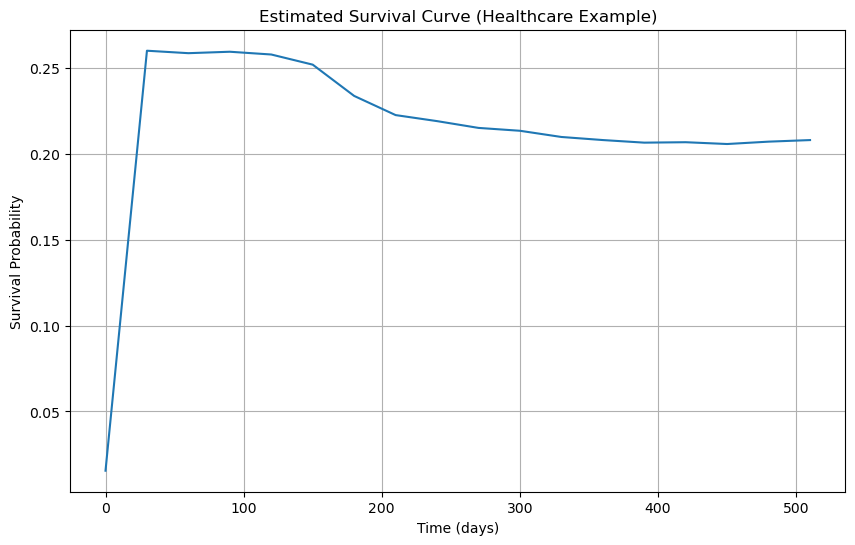

In [17]:
# Average survival curve
mean_sv = np.mean(sv_prob, axis=(0, 1))  # Average over samples and individuals

time_points = np.arange(len(mean_sv)) * 30  # Back to days

plt.figure(figsize=(10, 6))
plt.plot(time_points, mean_sv)
plt.xlabel('Time (days)')
plt.ylabel('Survival Probability')
plt.title('Estimated Survival Curve (Healthcare Example)')
plt.grid(True)
plt.show()

### Interpretation
This example demonstrates how BART-Survival can model complex, non-linear relationships in healthcare survival data without assuming proportional hazards. The synthetic data shows how covariates like age and treatment influence survival.

